# Explore here

In [25]:
import pandas as pd

# Cargar el conjunto de datos
url = "https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv"
data = pd.read_csv(url)

# Mostrar las primeras filas del conjunto de datos
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Paso 2: Preproceso de los Datos

In [26]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# Descargar recursos necesarios
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_url(url):
    # Segmentar la URL utilizando signos de puntuación
    tokens = re.split(r'\W+', url)
    # Convertir a minúsculas y eliminar stopwords
    tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    # Lematizar
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# Aplicar el preprocesamiento a las URLs
data['processed_url'] = data['url'].apply(preprocess_url)

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Dividir el conjunto de datos en train y test
X_train, X_test, y_train, y_test = train_test_split(data['processed_url'], data['is_spam'], test_size=0.2, random_state=41)

# Verificar división
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2399,) (600,) (2399,) (600,)


In [28]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

pipeline = make_pipeline(TfidfVectorizer(), SVC())

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

report_default = classification_report(y_test, y_pred, output_dict=True)
accuracy_default = accuracy_score(y_test, y_pred)
print("\nDefault Model Report")
print(classification_report(y_test, y_pred))


Default Model Report
              precision    recall  f1-score   support

       False       0.95      0.96      0.95       445
        True       0.87      0.85      0.86       155

    accuracy                           0.93       600
   macro avg       0.91      0.90      0.91       600
weighted avg       0.93      0.93      0.93       600



Optimizar Modelo con Grid Search

In [29]:
from sklearn.model_selection import GridSearchCV

# Definir los parametros para el Grid Search
param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': [1, 0.1, 0.01],
    'svc__kernel': ['rbf', 'linear']
}

# Configurar el Grid Search
grid = GridSearchCV(pipeline, param_grid, refit=True, verbose=2)

# Entrenar el modelo optimizado
grid.fit(X_train, y_train)

# Predecir en el conjunto de prueba con el mejor modelo
y_pred_optimized = grid.best_estimator_.predict(X_test)

report_optimized = classification_report(y_test, y_pred_optimized, output_dict=True)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print("\nOptimized Model Report")
print(classification_report(y_test, y_pred_optimized))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END ..........svc__C=0.1, svc__gamma=1, svc__kernel=rbf; total time=   0.3s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END .......svc__C=0.1, svc__gamma=1, svc__kernel=linear; total time=   0.2s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc__kernel=rbf; total time=   0.2s
[CV] END ........svc__C=0.1, svc__gamma=0.1, svc

Guardar modelo optimizado

In [30]:
import joblib

# Guardar el modelo optimizado
joblib.dump(grid.best_estimator_, 'svm_spam_detector.pkl')

['svm_spam_detector.pkl']

Comparar modelo original y modelo optimizado

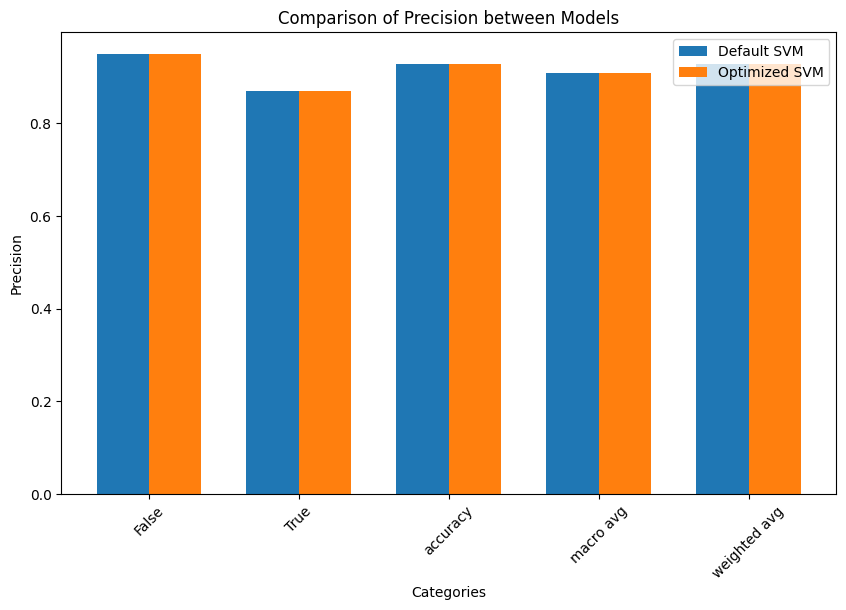

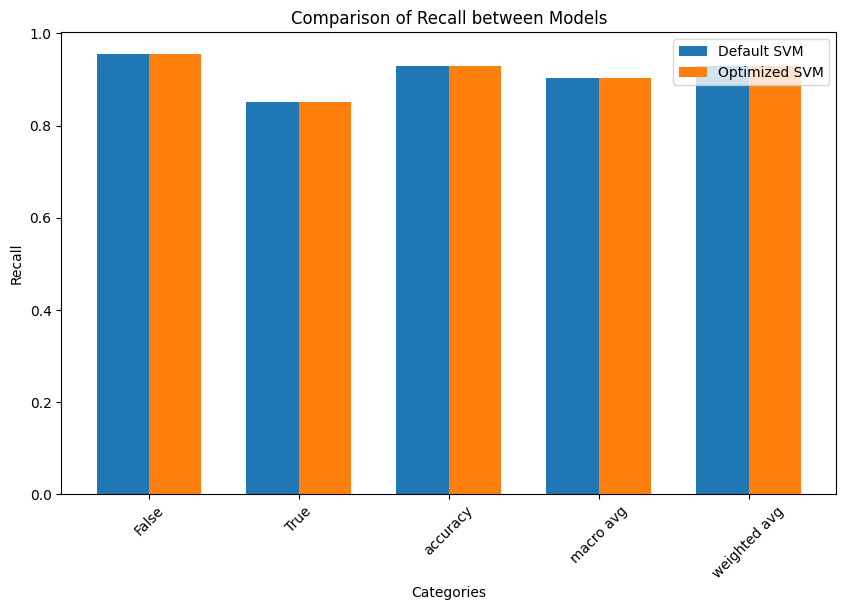

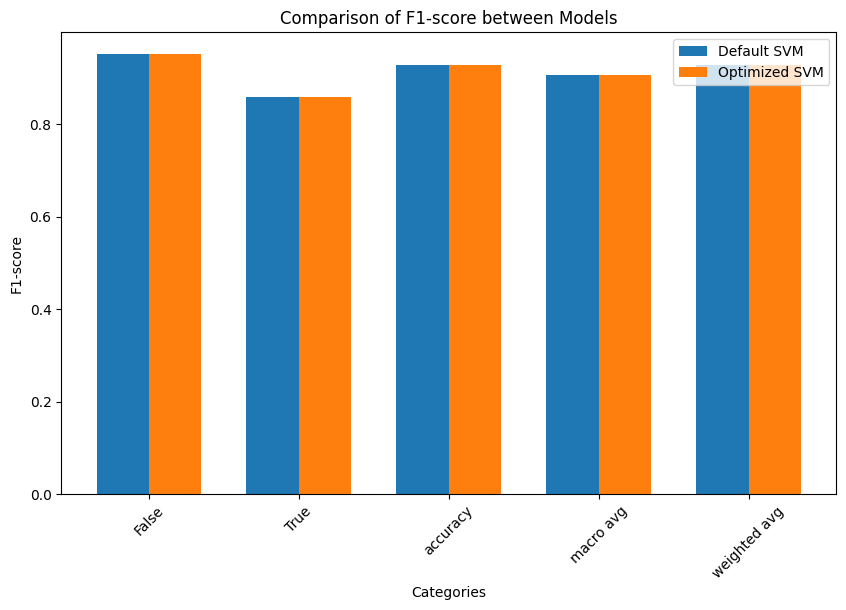

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer métricas de los informes
categories = ['False', 'True', 'accuracy', 'macro avg', 'weighted avg']
metrics = ['precision', 'recall', 'f1-score']

# Crear DataFrames para ambos modelos
df_default = pd.DataFrame(report_default).transpose()
df_optimized = pd.DataFrame(report_optimized).transpose()

# Filtrar solo las categorías necesarias
df_default = df_default.loc[categories]
df_optimized = df_optimized.loc[categories]

# Función para crear gráficos de barras
def plot_metric_comparison(metric):
    plt.figure(figsize=(10, 6))
    x = np.arange(len(categories))
    width = 0.35  # El ancho de las barras

    rects1 = plt.bar(x - width/2, df_default[metric], width, label='Default SVM')
    rects2 = plt.bar(x + width/2, df_optimized[metric], width, label='Optimized SVM')

    plt.xlabel('Categories')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} between Models')
    plt.xticks(x, categories, rotation=45)
    plt.legend()

    plt.show()

# Graficar todas las métricas
for metric in metrics:
    plot_metric_comparison(metric)

Podemos observar que entre el modelo original y el modelo optimizado utilizando Grid Search NO hay diferencias visibles en las predicciones en ninguna de las métricas principales (precision, accuracy, recall o F1-score)